# Accessing Lower Level Algorithms (CG, Lanczos, Arnoldi, etc)

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

import time
import torch
import cola
import jax.numpy as jnp

Let's construct a simple example matrix with a rapidly decaying spectrum, such as an RBF kernel.

In [2]:
from cola.linalg.eig.power_iteration import power_iteration
N = 3_000
x = torch.linspace(-1, 1, N)
C = cola.lazify(torch.exp(-(x[None] - x[:, None])**2 / 2))
_, eigmax, _ = power_iteration(C, tol=1e-2)
C = C + 1e-4 * eigmax * cola.ops.I_like(C)

/home/ubu/cola/cola/backends/torch_fns.py:299: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(arr, dtype=dtype, device=device)


We can run CG, GMRES to perform solves, or lanczos and arnoldi for decompositions to compute $f(A)v$ for a vector $v$ or for estimating the extremal eigenvalues.

In [3]:
y = torch.randn(C.shape[-1])
sol, info = cola.CG(tol=1e-4, pbar=True)(C, y)
sol1, info1 = cola.GMRES(tol=1e-4, pbar=True)(C, y)
Q1, T, info2 = cola.Lanczos(pbar=True, tol=1e-4, max_iters=1000)(C)
Q2, H, info3 = cola.Arnoldi(pbar=True, tol=1e-4, max_iters=1000)(C)

Running body_fun:   0%|          | 0/100 [00:00<?, ?it/s]

Running body_fun:   0%|          | 0/100 [00:00<?, ?it/s]

Running body_fun:   0%|          | 0/100 [00:00<?, ?it/s]

Running body_fun:   0%|          | 0/100 [00:00<?, ?it/s]

Information on the convergence criteria, number of iterations used, and the time per iteration is returned in the info dictionary. We can also use `pbar=True` to track the convergence with a tqdm progressbar.

In [4]:
print(info)

{'iterations': 14, 'errors': array([1.27016869e+01, 4.56182146e+00, 7.67108202e-01, 6.68334901e-01,
       1.62332971e-02, 2.40657702e-01, 1.76254776e-03, 1.06712850e-03,
       2.43267021e-03, 5.13068459e-04, 2.26660675e-04, 7.98909969e-06,
       7.98909969e-06]), 'iteration_time': 0.0022912025451660156}


Let's plot the convergence criteria for these different algorithms:

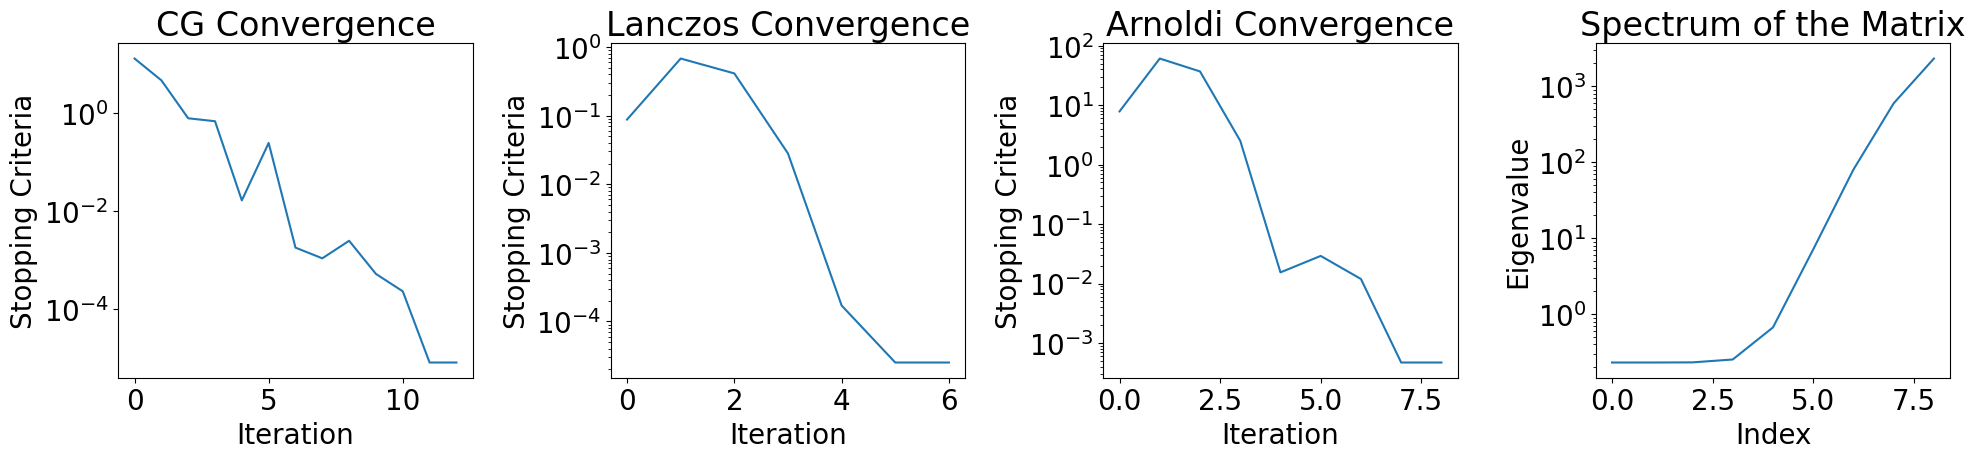

In [5]:
eigs = cola.eig(cola.SelfAdjoint(C), k=C.shape[0])[0]

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 20
algorithms = [('CG', info), ('Lanczos', info2), ('Arnoldi', info3)]
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, (name, info) in enumerate(algorithms):
    axs[i].plot(info['errors'])
    axs[i].set_yscale('log')
    axs[i].set_title(f'{name} Convergence')
    axs[i].set_xlabel('Iteration')
    axs[i].set_ylabel('Stopping Criteria')

axs[3].plot(eigs)
axs[3].set_yscale('log')
axs[3].set_title('Spectrum of the Matrix')
axs[3].set_xlabel('Index')
axs[3].set_ylabel('Eigenvalue')

plt.tight_layout()
plt.show()

For CG, the residual $\|Ax-b\|$ is the stopping criteria, whereas for Lanczos and Arnoldi it is diagonal entries in the Tridiagonal and Upper Hessenberg matrices respectively.

One tricky thing is that if you `jit` the algorithm or a function containing the algorithm, then the info dict will no longer be populated as jitted methods must always return arrays of the same shape. (though the progress bar will still be updated)

In [6]:
import jax

C_jax = cola.lazify(jnp.array(C.to_dense()))
y_jax = jnp.array(y)


def mycg(C, y):
    return cola.CG(tol=1e-4, pbar=True)(C, y)


solj, infoj = jax.jit(mycg)(C_jax, y_jax)

Running body_fun:   0%|          | 0/100 [00:00<?,?it/s]

In [7]:
print(infoj)

{}
